# chips-net analysis

This notebook outlines the main findings from chips-net and the path taken to get to the final version...

In [1]:
# Input parameters for this notebook...
config_path = "/mnt/storage/jtingey/chips-net/config/eval.yaml"

In [2]:
# Import the standard modules required
import time
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 

# Setup Tensorflow and the GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

# chipsnet imports
import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)

In [4]:
reload()
# Load the configuration and get all the dataframes and models
config = chipsnet.config.get(config_path)

# Get the data loaders for each of the datasets
beam_flux_data = chipsnet.utils.data_from_conf(config, 'beam_flux')
beam_uniform_data = chipsnet.utils.data_from_conf(config, 'beam_uniform')

# Load data into the pandas dataframes
num_examples = int(config.eval.examples)
beam_flux_events = beam_flux_data.testing_df(num_events=num_examples)
beam_uniform_events = beam_uniform_data.testing_df(num_events=num_examples)

# Get all the models we want to use in evaluation
beam_flux_model = chipsnet.utils.model_from_conf(config, 'beam_flux')
beam_uniform_model = chipsnet.utils.model_from_conf(config, 'beam_uniform')
cosmic_model = chipsnet.utils.model_from_conf(config, 'cosmic')

In [5]:
# Run inference on all the datasets through all the models
reload()

print("Running beam_flux data through beam_flux model...")
beam_flux_events = chipsnet.utils.run_inference(beam_flux_data, beam_flux_events, beam_flux_model, num_examples, prefix='beam_flux')
print("Running beam_flux data through beam_uniform model...")
beam_flux_events = chipsnet.utils.run_inference(beam_flux_data, beam_flux_events, beam_uniform_model, num_examples, prefix='beam_uniform')
print("Running beam_flux data through cosmic model...")
beam_flux_events = chipsnet.utils.run_inference(beam_flux_data, beam_flux_events, cosmic_model, num_examples, prefix='cosmic')

print("Running beam_uniform data through beam_flux model...")
beam_uniform_events = chipsnet.utils.run_inference(beam_uniform_data, beam_uniform_events, beam_flux_model, num_examples, prefix='beam_flux')
print("Running beam_uniform data through beam_uniform model...")
beam_uniform_events = chipsnet.utils.run_inference(beam_uniform_data, beam_uniform_events, beam_uniform_model, num_examples, prefix='beam_uniform')
print("Running beam_uniform data through cosmic model...")
beam_uniform_events = chipsnet.utils.run_inference(beam_uniform_data, beam_uniform_events, cosmic_model, num_examples, prefix='cosmic')

Running beam_flux data through beam_flux model...
Running beam_flux data through beam_uniform model...
Running beam_flux data through cosmic model...
Running beam_uniform data through beam_flux model...
Running beam_uniform data through beam_uniform model...
Running beam_uniform data through cosmic model...


In [6]:
# Add the event weights to the dataframes so we can scale plots appropriately
beam_flux_events = chipsnet.utils.apply_weights(
    beam_flux_events,
    config.eval.weights.total,
    config.eval.weights.nuel,
    config.eval.weights.anuel,
    config.eval.weights.numu,
    config.eval.weights.anumu,
    config.eval.weights.cosmic
)
beam_uniform_events = chipsnet.utils.apply_weights(
    beam_flux_events,
    config.eval.weights.total,
    config.eval.weights.nuel,
    config.eval.weights.anuel,
    config.eval.weights.numu,
    config.eval.weights.anumu,
    config.eval.weights.cosmic
)

el:0.0047(8211), ael:0.0004(6195), mu:0.3589(9343), amu:0.0146(5019), cos:374.5971(3232)
el:0.0047(8211), ael:0.0004(6195), mu:0.3589(9343), amu:0.0146(5019), cos:374.5971(3232)


In [7]:
# Apply the default cuts to the events
beam_flux_events['raw_total_digi_q_cut'] = beam_flux_events.apply(
    chipsnet.utils.cut_apply('r_raw_total_digi_q', config.eval.cuts.q, type='greater_than'),
    axis=1
)
beam_uniform_events['raw_total_digi_q_cut'] = beam_flux_events.apply(
    chipsnet.utils.cut_apply('r_raw_total_digi_q', config.eval.cuts.q, type='greater_than'),
    axis=1
)

beam_flux_events['first_ring_height_cut'] = beam_flux_events.apply(
    chipsnet.utils.cut_apply('r_first_ring_height', config.eval.cuts.hough, type='greater_than'),
    axis=1
)
beam_uniform_events['first_ring_height_cut'] = beam_flux_events.apply(
    chipsnet.utils.cut_apply('r_first_ring_height', config.eval.cuts.hough, type='greater_than'),
    axis=1
)

# TODO: Also include the reconstructed direction cuts, need to rerun all the maps for this...

## The input images

First let's explore the input event 'hit maps' we can use as input to the network.

Figuring out how best to represent the 2D surface of a cylindrical detector for a 2d convolutional network is a challenge.
The simplest approach would be to ignore the endcaps and just use a square/rectangular map of the detector barrel as input.
However, a large fraction of the Cherenkov light collected by the detector hits the endcaps so we will be loosing a lot of infomation...

The other possible ways of representing the 

 - afaf
 - faff

In [3]:
# Setup the configuration variables for plotting the events
nuel_file = "/mnt/storage/jtingey/chips-net/data/maps/chips_1200/beam_all_nuel/selected_000_sim_map.root"
numu_file = "/mnt/storage/jtingey/chips-net/data/maps/chips_1200/beam_all_numu/selected_000_sim_map.root"
image_size = [64, 64]
images = {
    "r_raw_charge_map_origin": [],
    "r_raw_charge_map_iso": [],
    "r_raw_charge_map_vtx": [],
    "r_raw_time_map_origin": [],
    "r_raw_time_map_iso": [],
    "r_raw_time_map_vtx": [],
    "r_raw_hit_hough_map_vtx": []
}
channel_hists = images

In [4]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_file)
numu_file = uproot.open(numu_file)
for image_name in images.keys():
    images[image_name].extend(nuel_file['reco'].array(image_name))
    images[image_name].extend(numu_file['reco'].array(image_name))

### Fraction of charge in endcaps

In [6]:
cap_total = 0
barrel_total = 0
for event in beam_flux_events['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4329965485152668


### Different views

In [7]:
def plot_hit_time(images_dict, event):
    fig, axs = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs[0, 0].imshow(images['r_raw_charge_map_origin'][event], cmap='Reds', origin='lower')
    axs[0, 0].set_title('$\phi$ and $\\theta$ from origin')
    axs[0, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[0, 1].imshow(images['r_raw_charge_map_iso'][event], cmap='Reds', origin='lower')
    axs[0, 1].set_title('$x^{+}$ and $x^{-}$ from origin')
    axs[0, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[0, 2].imshow(images['r_raw_charge_map_vtx'][event], cmap='Reds', origin='lower')
    axs[0, 2].set_title('$\phi$ and $\\theta$ from vertex')
    axs[0, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[0, 2].text(68, -3, 'Desposited charge images', rotation=-90)

    axs[1, 0].imshow(images['r_raw_time_map_origin'][event], cmap='Reds', origin='lower')
    axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[1, 1].imshow(images['r_raw_time_map_iso'][event], cmap='Reds', origin='lower')
    axs[1, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[1, 2].imshow(images['r_raw_time_map_vtx'][event], cmap='Reds', origin='lower')
    axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[1, 2].text(68, 2, 'First hit time images', rotation=-90)
    
def plot_hough(images_dict, event):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs.imshow(images['r_raw_hit_hough_map_vtx'][event], cmap='Reds', origin='lower')
    axs.set_title('$\phi$ and $\\theta$ from origin')
    axs.set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs.text(68, 12, 'Hough space image', rotation=-90)

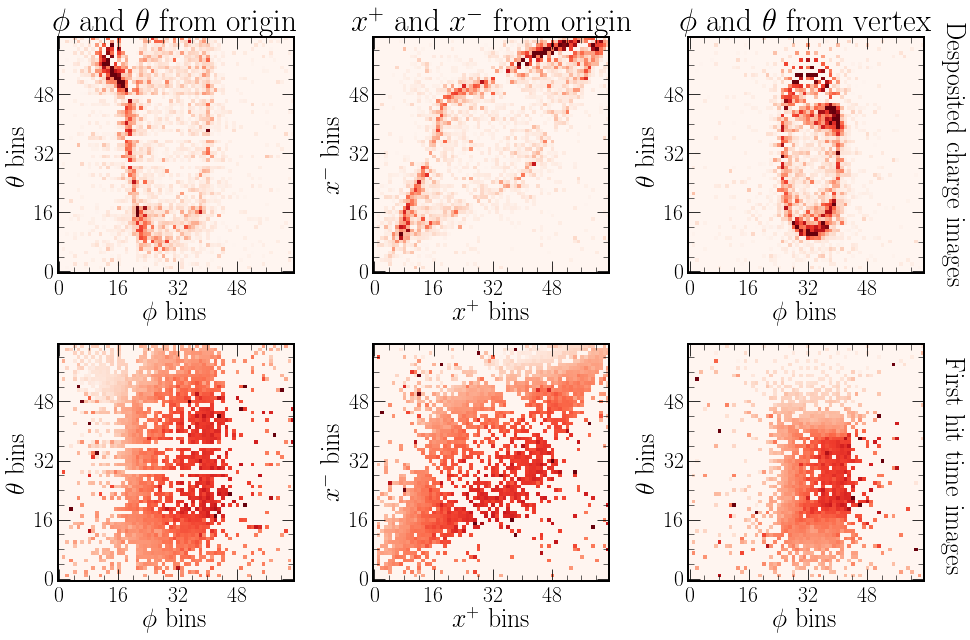

In [8]:
plot_hit_time(images_dict, 1)

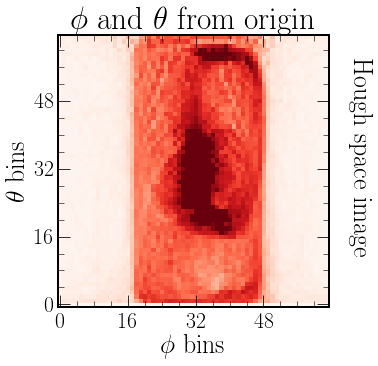

In [9]:
plot_hough(images_dict, 1)

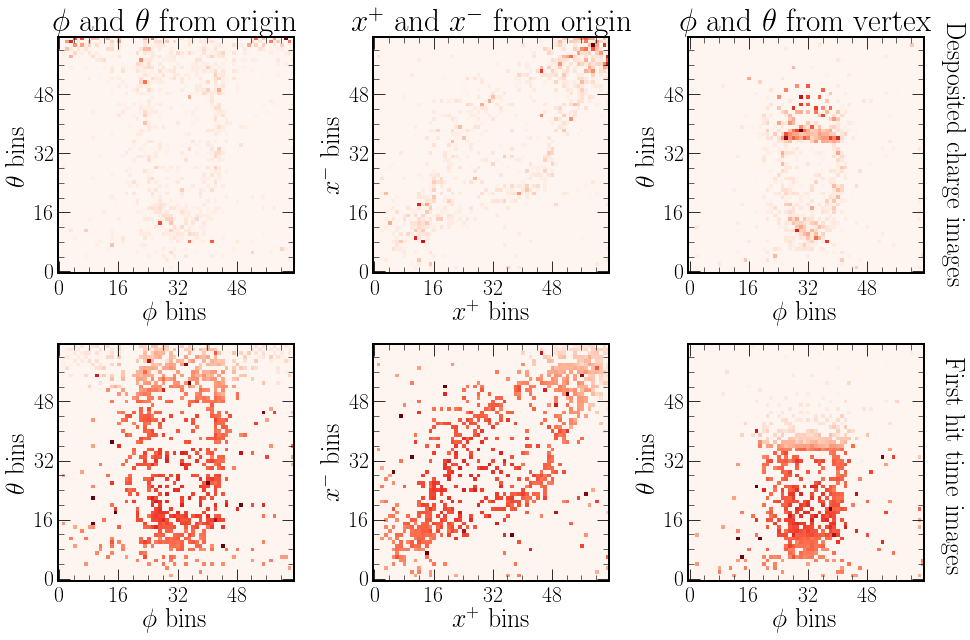

In [10]:
plot_hit_time(images_dict, 2081)

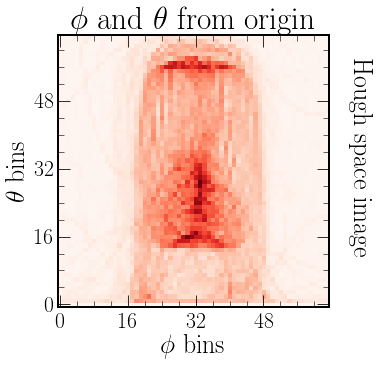

In [11]:
plot_hough(images_dict, 2081)

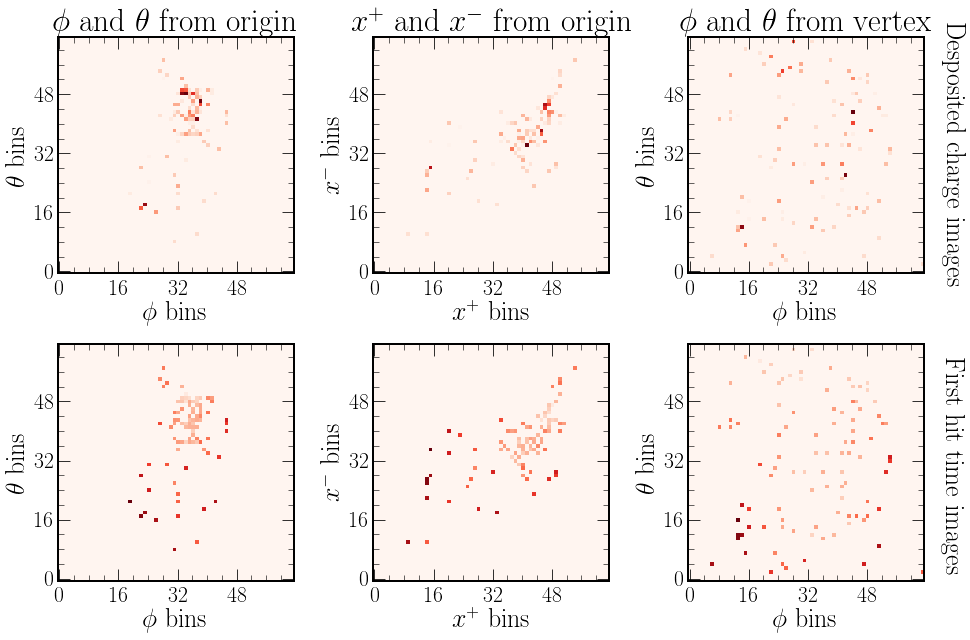

In [12]:
plot_hit_time(images_dict, 13)

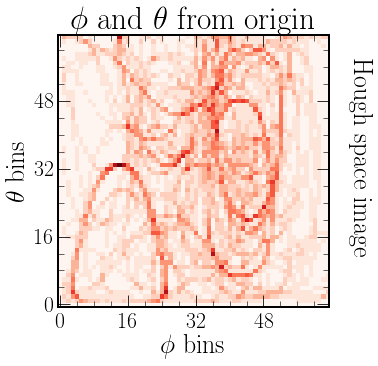

In [13]:
plot_hough(images_dict, 13)

### Defining ranges for 8-bit encoding

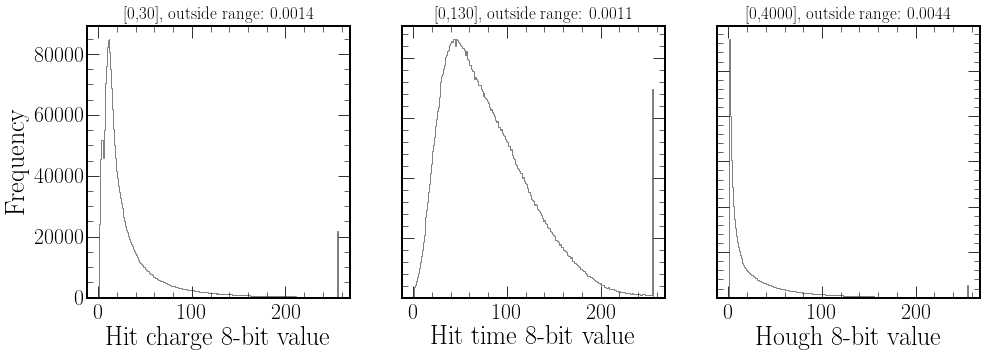

In [29]:
def plot_8bit_range(images_dict, max_charge=30, max_time=130, max_hough=4000):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    #plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    
    hist_data = []
    for event in images_dict['r_raw_charge_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[0].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[0].set_title("[0,{}], outside range: {:.4f}".format(max_charge, occurrences), fontsize=17)
    axs[0].set(xlabel='Hit charge 8-bit value', ylabel='Frequency')
    axs[0].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_time_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[1].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[1].set_title("[0,{}], outside range: {:.4f}".format(max_time, occurrences), fontsize=17)
    axs[1].set(xlabel='Hit time 8-bit value', ylabel='Frequency')
    axs[1].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_hit_hough_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[2].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[2].set_title("[0,{}], outside range: {:.4f}".format(max_hough, occurrences), fontsize=17)
    axs[2].set(xlabel='Hough 8-bit value', ylabel='Frequency')
    axs[2].label_outer()

plot_8bit_range(images)

## Explainability

In [18]:
config_path = '/mnt/storage/jtingey/chips-net/config/train_beam.yaml'
config = chipsnet.config.get(config_path)
chipsnet.config.setup_dirs(config, False)

model = chipsnet.models.get_model(config)
model.load()

Model: "multi_simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_0 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
path0_block1 (VGGBlock)         (None, 32, 32, 64)   39104       image_0[0][0]                    
__________________________________________________________________________________________________
path0_block2 (VGGBlock)         (None, 16, 16, 128)  222208      path0_block1[0][0]               
__________________________________________________________________________________________________
path0_block3 (VGGBlock)         (None, 8, 8, 256)    1477632     path0_block2[0][0]               
_______________________________________________________________________________________

In [22]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.gradients_inputs import GradientsInputs

single_output_model = tf.keras.Model(  # Model to ouput cosmic model dense layer
    inputs=model.model.input,
    outputs=model.model.get_layer('t_all_cat').output
)
data = chipsnet.data.Reader(config)
ds = data.testing_ds

grad_cams_1 = []
grad_cams_2 = []
grad_cams_3 = []
occlusions = []
activations_1 = []
activations_2 = []
activations_3 = []
vanilla_grads = []
smooth_grads = []
int_grads = []
imput_grads = []
for inputs, labels in ds.take(10):
    event_class = int(labels['t_all_cat'])
    image = tf.expand_dims(inputs['image_0'], axis=0).numpy()

    grad_cams_1.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block1"))
    grad_cams_2.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block2"))
    grad_cams_3.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block3"))
    occlusions.append(OcclusionSensitivity().explain((image, event_class), single_output_model, class_index=event_class, patch_size=3))
    activations_1.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block1_conv0'))
    activations_2.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block2_conv0'))
    activations_3.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block3_conv0'))
    vanilla_grads.append(VanillaGradients().explain((image, event_class), single_output_model, class_index=event_class))
    smooth_grads.append(SmoothGrad().explain((image, event_class), single_output_model, class_index=event_class))
    int_grads.append(IntegratedGradients().explain((image, event_class), single_output_model, class_index=event_class))
    imput_grads.append(GradientsInputs().explain((image, event_class), single_output_model, class_index=event_class))

[Text(0, 0.5, '$\\theta$ bins'),
 Text(0.5, 0, '$\\phi$ bins'),
 Text(0.5, 1.0, 'Input times gradients')]

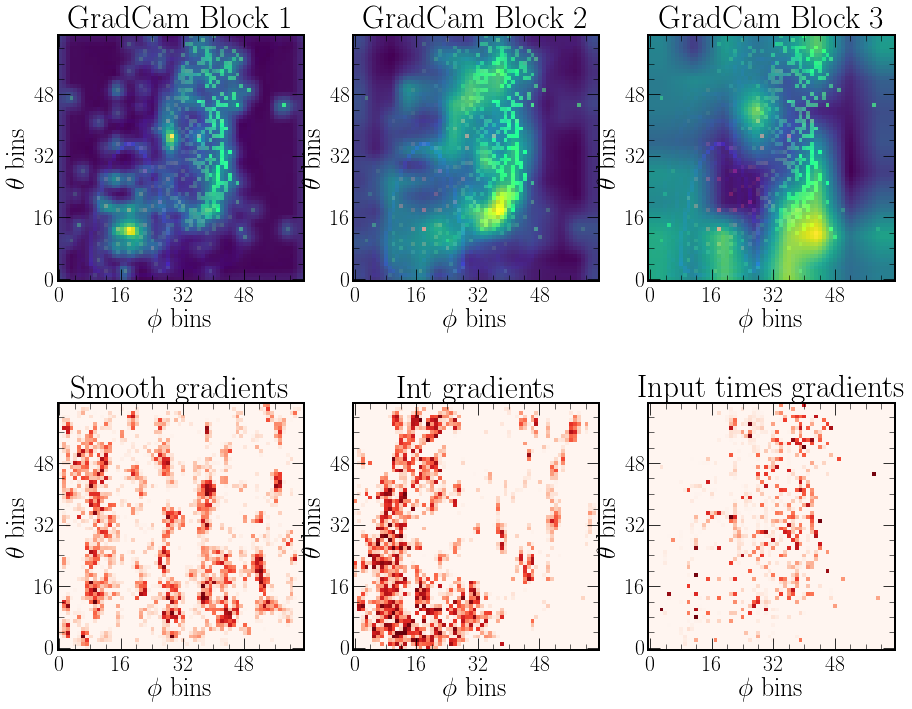

In [23]:
event = 9
fig, axs = plt.subplots(2, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0, 0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[0, 1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[0, 1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[0, 2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[0, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
axs[1, 0].imshow(smooth_grads[event], cmap='Reds', origin='lower')
axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Smooth gradients')
axs[1, 1].imshow(int_grads[event], cmap='Reds', origin='lower')
axs[1, 1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Int gradients')
axs[1, 2].imshow(imput_grads[event], cmap='Reds', origin='lower')
axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Input times gradients')

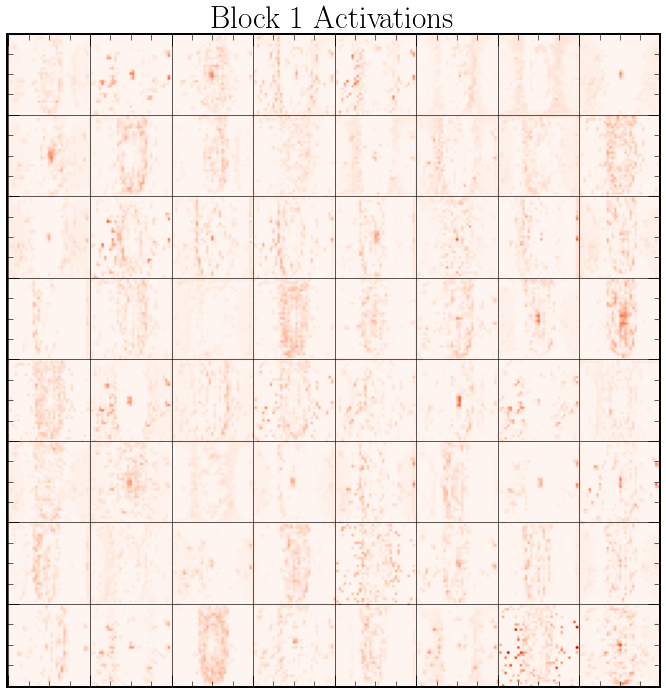

In [24]:
event = 2
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, xticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], yticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], 
         xticklabels=['', '', '', '', '', '', '', ''], yticklabels=['', '', '', '', '', '', '', ''])
axs.imshow(activations_1[event], cmap='Reds', origin='lower')
axs.set(title='Block 1 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

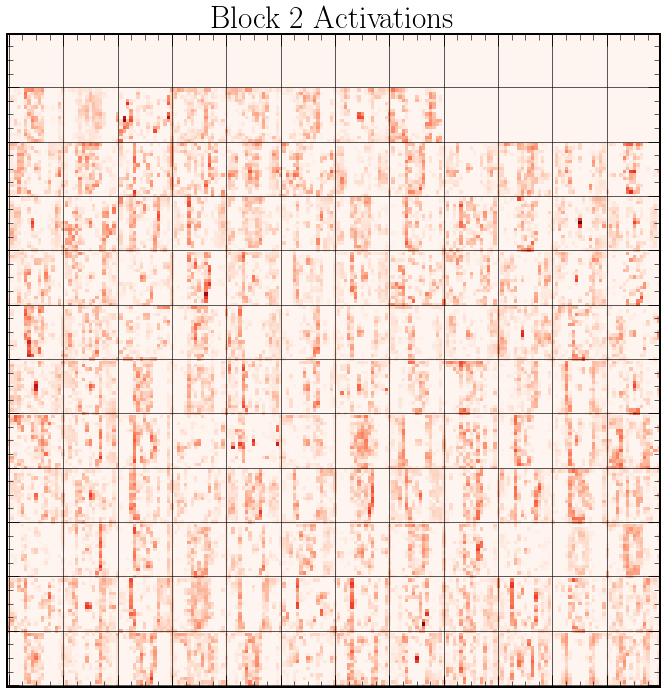

In [25]:
event = 2
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, xticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], yticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], 
         xticklabels=['', '', '', '', '', '', '', ''], yticklabels=['', '', '', '', '', '', '', ''])
axs.imshow(activations_2[event], cmap='Reds', origin='lower')
axs.set(title='Block 2 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

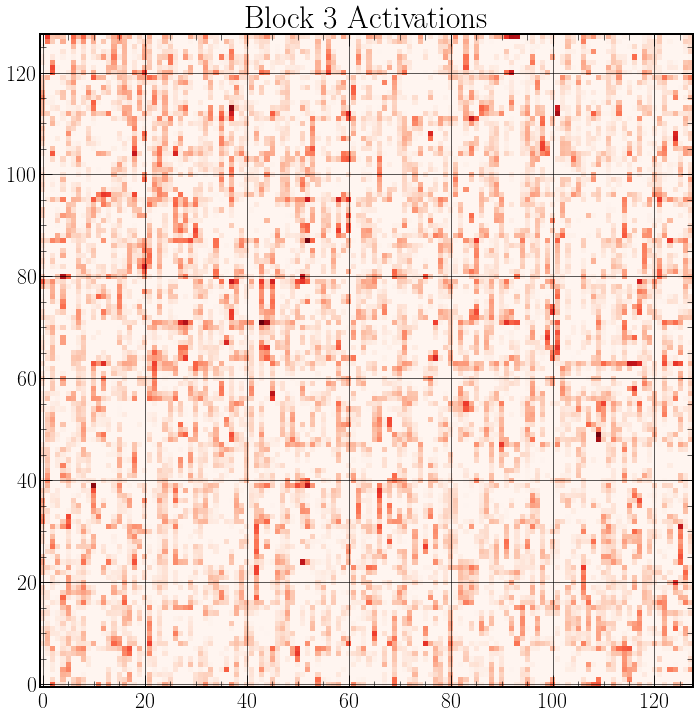

In [27]:
event = 2
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
axs.imshow(activations_3[event], cmap='Reds', origin='lower')
axs.set(title='Block 3 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()